# Uso de Datasets Desbalanceados

In [5]:
import pandas as pd

dataset_url = "/content/wine-reviews-sem_rotulos-30.csv"
df = pd.read_csv(dataset_url, nrows=2000)

print(f"DataFrame shape: {df.shape}")

DataFrame shape: (2000, 15)


In [6]:
# a) Liste os campos que compõem cada registro
print("Campos do dataset:", df.columns.tolist())

Campos do dataset: ['Unnamed: 0', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery', 'classification']


In [7]:
# b) Liste os labels das classes existentes
if "classification" in df.columns:
    # Exibir classes únicas presentes na coluna de classification
    classification_unicos = df["classification"].unique()
    print(len(classification_unicos))
    print("classification das classes existentes:", classification_unicos)

else:
    print("A coluna 'classification' não foi encontrada no dataset.")


5
classification das classes existentes: ['Bom' nan 'Ótimo' 'Regular' 'Excelente']


In [8]:
# c) Liste a quantidade de registros que não contenham label, que contenham um label, dois labels, até o máximo de labels existentes.
if "classification" in df.columns:
    # Contar quantos labels cada registro possui
    label_counts = df["classification"].apply(lambda x: len(x) if isinstance(x, list) else 0)

    # Contar a quantidade de registros com cada número de labels
    print(label_counts.value_counts().to_frame().T)

classification     0
count           2000


In [9]:
# d) Liste a quantidade de registros associados a cada label/classe existente
df_counts = df["classification"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 4


classification,Bom,Ótimo,Regular,Excelente
count,805,499,86,42


In [10]:
# 4) Identifique quais labels/classes serão utilizados na atividade de classificação a ser realizada. Aplique um filtro apropriado para uso destes registros na atividade.
# Serão utilizados todos as labels/classes
label_map = {"Bom": "Bom",
             "Ótimo": "Ótimo",
             "Regular": "Regular",
             "Excelente": "Excelente"}
all_labels = list(label_map.values())

'''
def filter_labels(label):
    return label_map[label] if label in label_map else label

df["classification"] = df["classification"].apply(filter_labels)
'''

df_counts = df["classification"].explode().value_counts()
df_counts.to_frame()

,count
classification,
Bom,805
Ótimo,499
Regular,86
Excelente,42


In [11]:
# e) Liste a quantidade de registros com labels/classes e sem labels/classes
# 5) Crie uma nova coluna no dataframe do Pandas que você está utilizando para indicar se o registro possui label ou não.
df["split"] = "unlabeled"
mask = df["classification"].apply(lambda x: len(x) if pd.notna(x) else 0) > 0
df.loc[mask, "split"] = "labeled"
df["split"].value_counts().to_frame()

,count
split,
labeled,1432
unlabeled,568


In [ ]:
for column in ["country", "designation", "classification"]:
    print(f"{column}: {df[column].iloc[26][:500]}\n")

In [12]:
# 6) Caso dois ou mais campos contenham informação textual de interesse para a análise, avalie a possibilidade de concatená-los em um único campo.
# Não foi necessário, mas poderia ser feito
'''
df["text"] = (df.apply(lambda x: x["description"] + "\n\n" + x["country"], axis=1))
'''

'\ndf["text"] = (df.apply(lambda x: x["description"] + "\n\n" + x["country"], axis=1))\n'

In [13]:
# 7) Identifique possíveis registros duplicados e remova-os.
len_before = len(df)
df = df.drop_duplicates(subset="description")
print(f"Removed {(len_before-len(df))/len_before:.2%} duplicates.")

Removed 0.00% duplicates.


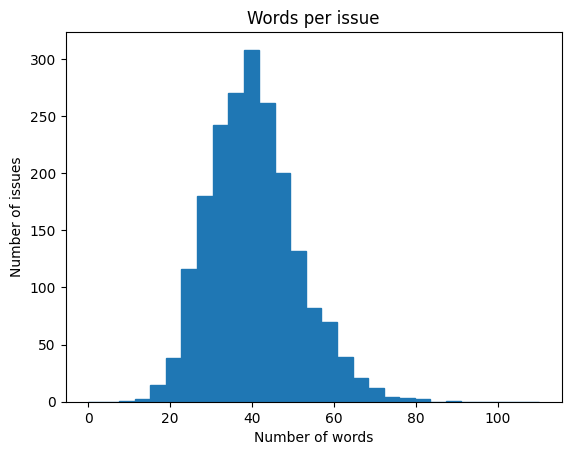

In [14]:
# 8) Apresente um gráfico para mostrar a distribuição de quantidade de palavras por registro.
import numpy as np
import matplotlib.pyplot as plt

(df["description"].str.split().apply(len)
 .hist(bins=np.linspace(0, 110, 30), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

## Creating Training Sets
### 9) Utilize a biblioteca Scikit-multilearn para criar os conjuntos de registros para treinamento, validação e teste.

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])

MultiLabelBinarizer()

In [2]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00


In [16]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["classification"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [17]:
from sklearn.model_selection import train_test_split

df_clean = df[["description", "classification", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["description", "classification"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["description", "classification"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['B', 'E', 'R', 'a', 'c', 'e', 'g', 'i', 'l', 'm', 'n', 'o', 'r', 't', 'u', 'x', 'Ó'] will be ignored
  warnings.warn(


In [3]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.4 MB/s eta 0:00:00


In [18]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

## Creating Training Slices
### 10) Crie os training slices do seu dataset.


In [19]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["classification"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['B', 'E', 'R', 'a', 'c', 'e', 'g', 'i', 'l', 'm', 'n', 'o', 'r', 't', 'u', 'x', 'Ó'] will be ignored
  warnings.warn(


In [20]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 716]
Actual split sizes:
[8, 16, 32, 64, 128, 716]


## Implementing a Naive Bayesline
### 11) Implemente o Naive Bayesline e apresente os gráficos para Micro e Macro F1 score.

In [21]:
#hide_output
def prepare_labels(batch):
    # Substituir None por uma lista vazia para evitar erro
    batch["label_ids"] = mlb.transform([[x] if x is not None else [] for x in batch["classification"]])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Map:   0%|          | 0/358 [00:00<?, ? examples/s]

Map:   0%|          | 0/358 [00:00<?, ? examples/s]

Map:   0%|          | 0/568 [00:00<?, ? examples/s]

In [22]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # (x) Print unique classes in the training slice
    print(f"Unique classes in training slice {i}: {np.unique(y_train)}")

    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["description"])
    X_test_counts = count_vect.transform(ds["test"]["description"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

    # (x) Print scores
    print(f"Iteration {i+1}/{len(train_slices)} - Macro F1: {macro_scores['Naive Bayes'][-1]}, Micro F1: {micro_scores['Naive Bayes'][-1]}")

Unique classes in training slice 4: [0 1]
Iteration 5/6 - Macro F1: 0.17863554757630162, Micro F1: 0.5558659217877095
Unique classes in training slice 4: [0 1]
Iteration 5/6 - Macro F1: 0.17863554757630162, Micro F1: 0.5558659217877095
Unique classes in training slice 4: [0 1]
Iteration 5/6 - Macro F1: 0.18101603883552447, Micro F1: 0.5497896213183731
Unique classes in training slice 4: [0 1]
Iteration 5/6 - Macro F1: 0.18791766907244054, Micro F1: 0.5264750378214826
Unique classes in training slice 4: [0 1]
Iteration 5/6 - Macro F1: 0.18640494246861924, Micro F1: 0.5271317829457365
Unique classes in training slice 4: [0 1]
Iteration 5/6 - Macro F1: 0.3219518844135487, Micro F1: 0.6371681415929203


In [24]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

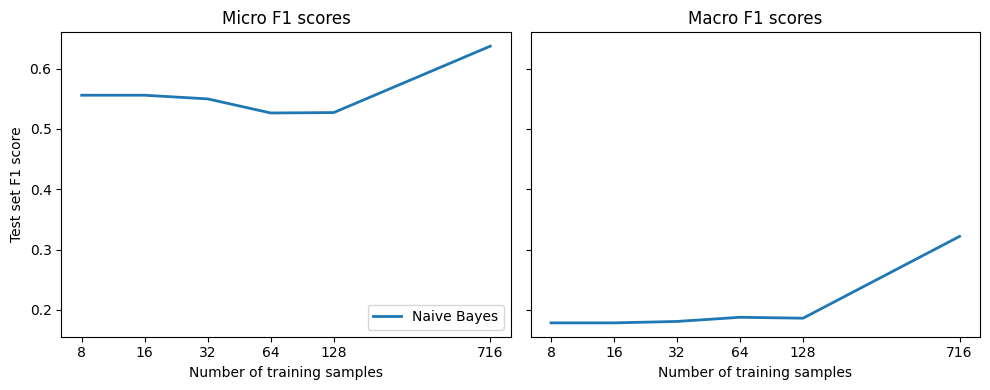

In [25]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

## GPT2 + FAISS
### 12) Utilize o recurso de embeddings, o gpt-2 disponível no Hugging Faces em "miguelvictor/python-gpt2-large" e os recursos oferecidos pelo FAISS para apresentar e discutir os resultados de micro e macro F1 score

In [26]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["description"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

In [27]:
# hide_output
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/716 [00:00<?, ? examples/s]

Map:   0%|          | 0/358 [00:00<?, ? examples/s]

Map:   0%|          | 0/358 [00:00<?, ? examples/s]

In [4]:
!pip install --no-cache-dir faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 12.6 MB/s eta 0:00:00


In [28]:
# hide_output
import faiss
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['description', 'classification', 'label_ids', 'embedding'],
    num_rows: 716
})

In [29]:
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['classification']}")
print(f"QUERY TEXT:\n{embs_valid[i]['description'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["classification"], samples["description"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

QUERY LABELS: Bom
QUERY TEXT:
Building on 150 years and six generations of winemaking tradition, the winery trends toward a leaner style, with the classic California buttercream aroma cut by tart green apple. In this good everyday [...]

Retrieved documents:
TEXT:
After three years en tirage, this well-evolved wine is heady and floral, made to highlight and celebrate diversity. Creamy and lush on the palate, it has a rounded richness of stone fruit. Made predom [...]
SCORE: 67.35
LABELS: Ótimo
TEXT:
From one of the best vintages in the last 15 years, this classic Barolo needs to be opened a couple of hours ahead of time to breathe. It's a bit shy on aromas but the palate delivers dried cherry, fi [...]
SCORE: 73.07
LABELS: Ótimo
TEXT:
A very good effort, this may be among the last great values to emerge from Australia, as smaller crops and changing currencies will undoubtedly take their toll. It's remarkable that McLaren Vale fruit [...]
SCORE: 73.24
LABELS: Bom


In [30]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [31]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

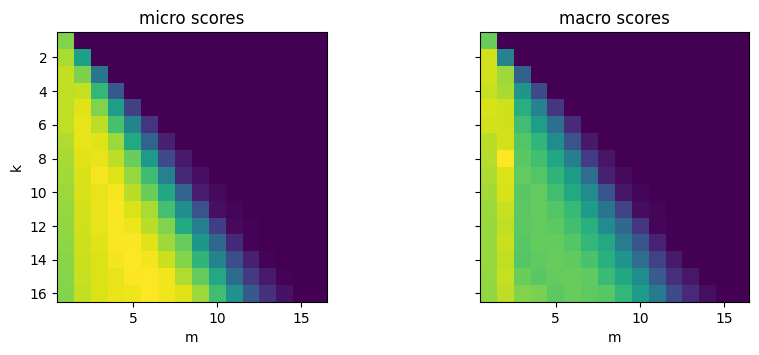

In [32]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [33]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 14, best m: 5


In [34]:
# hide_output
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

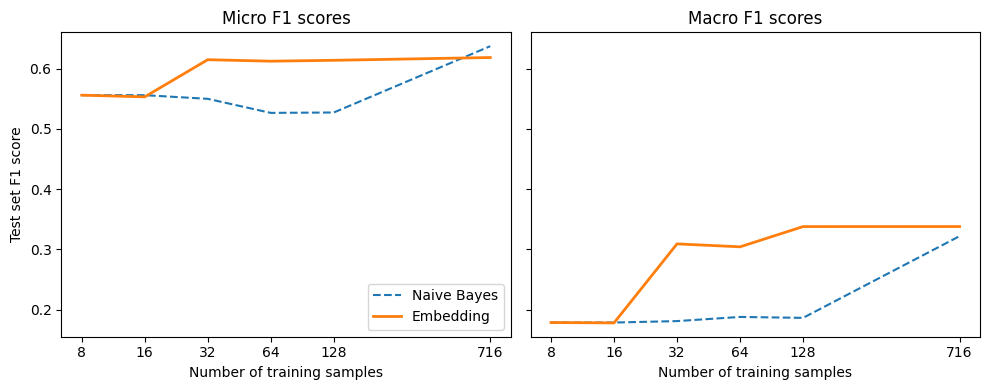

In [35]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")